<a href="https://colab.research.google.com/github/DarrenBarens/songs_data_exam/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Nov 24 00:42:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.9 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115441 sha256=a505a36eb336543744800d519dfe22ad1276b6185f59089262e0fc32af145355
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [ ]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')

1263889489/1263889489 [==============================] - 14s 0us/step


In [ ]:
print(path_to_training_data)

/root/.keras/datasets/train_face.h5


In [ ]:
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [ ]:
loader

In [ ]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [ ]:
number_of_training_examples

109914

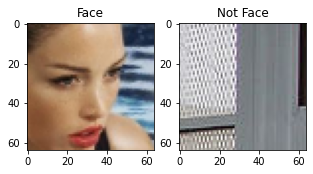

In [ ]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 34 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [ ]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

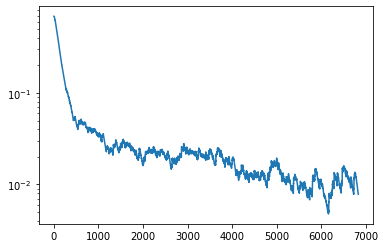

100%|██████████| 3434/3434 [00:30<00:00, 111.09it/s]


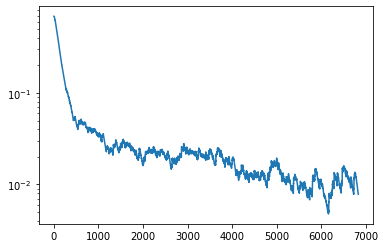

In [ ]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)
   

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())


In [ ]:
type(loss)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
y.shape

(32, 1)

In [ ]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 1s 2ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9928


In [ ]:
batch_x.shape

(5000, 64, 64, 3)

In [ ]:
batch_y.shape

(5000, 1)

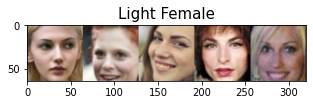

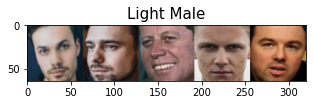

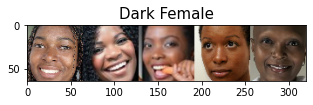

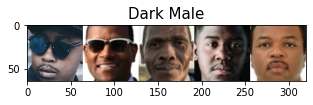

In [ ]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

In [ ]:
test_faces[1][3].size

12288

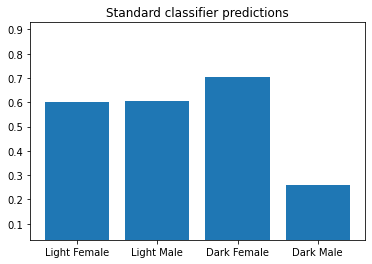

In [ ]:
### Evaluate the standard CNN on the test data ### 

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

In [ ]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # latent_loss = # TODO

  
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  # reconstruction_loss = # TODO

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  # vae_loss = # TODO
  
  return vae_loss

In [ ]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  # z = # TODO
  return z

In [ ]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )
  # total_loss = # TODO

  return total_loss, classification_loss

In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [ ]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
   
    z = sampling(z_mean, z_logsigma)
   
    return z
# Decode the latent space and output reconstruction
  def decode(self, z):
    
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    
    z = self.reparameterize(z_mean, z_logsigma)

  
    recon = self.decode(z)
  
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [ ]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [ ]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        
        #    every data sample falls in to
        
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
      
        p = p / np.sum(p)
        # p = # TODO
        
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
      
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p


Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

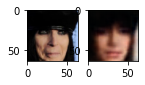

 14%|█▍        | 495/3434 [00:04<00:28, 104.78it/s]

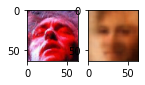

 29%|██▉       | 990/3434 [00:09<00:23, 104.53it/s]

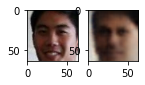

 44%|████▎     | 1496/3434 [00:14<00:18, 104.03it/s]

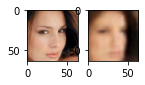

 58%|█████▊    | 1991/3434 [00:19<00:13, 103.18it/s]

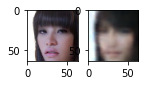

 73%|███████▎  | 2497/3434 [00:24<00:08, 104.30it/s]

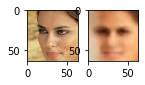

 87%|████████▋ | 2991/3434 [00:29<00:04, 103.22it/s]

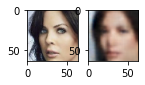

100%|██████████| 3434/3434 [00:34<00:00, 100.33it/s]


In [ ]:
### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    # loss, class_loss = debiasing_loss_function('''TODO arguments''') # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables)
  # grads = tape.gradient('''TODO''', '''TODO''') # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  # p_faces = get_training_sample_probabilities('''TODO''', '''TODO''') # TODO
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

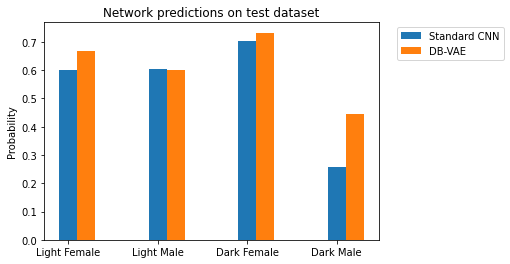

In [ ]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

# load data from Google drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
image = !unzip gdrive/MyDrive/CelebA/Img/img_align_celeba.zip

In [ ]:
image

['Archive:  gdrive/MyDrive/CelebA/Img/img_align_celeba.zip',
 '   creating: img_align_celeba/',
 ' extracting: img_align_celeba/000001.jpg  ',
 ' extracting: img_align_celeba/000002.jpg  ',
 ' extracting: img_align_celeba/000003.jpg  ',
 ' extracting: img_align_celeba/000004.jpg  ',
 ' extracting: img_align_celeba/000005.jpg  ',
 ' extracting: img_align_celeba/000006.jpg  ',
 ' extracting: img_align_celeba/000007.jpg  ',
 ' extracting: img_align_celeba/000008.jpg  ',
 ' extracting: img_align_celeba/000009.jpg  ',
 ' extracting: img_align_celeba/000010.jpg  ',
 ' extracting: img_align_celeba/000011.jpg  ',
 ' extracting: img_align_celeba/000012.jpg  ',
 ' extracting: img_align_celeba/000013.jpg  ',
 ' extracting: img_align_celeba/000014.jpg  ',
 ' extracting: img_align_celeba/000015.jpg  ',
 ' extracting: img_align_celeba/000016.jpg  ',
 ' extracting: img_align_celeba/000017.jpg  ',
 ' extracting: img_align_celeba/000018.jpg  ',
 ' extracting: img_align_celeba/000019.jpg  ',
 ' extracti

In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

## Load the dataset 
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

## Create a dataloader 
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

In [ ]:
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img('img_align_celeba/000944.jpg')
img

In [ ]:
img=img.convert('L')

In [ ]:
import cv2
from numpy import asarray

In [ ]:
img=asarray(img)

In [ ]:
img= cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)


In [ ]:
plt.imshow(img)

In [ ]:
len(image[6:-1])

In [ ]:
import tensorflow as tf
tf.__version__
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image
from numpy import asarray

In [ ]:
danni=list()
for i in image[10000:100000]:
  i=i[13:-2]
  img = tf.keras.preprocessing.image.load_img('{}'.format(i))
  numpydata = asarray(img)
  dis = cv2.resize(numpydata, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
  danni.append(dis)

In [ ]:
cat=np.array(danni)
y_pred_standard= tf.round(tf.nn.sigmoid(standard_classifier.predict(cat)))

In [ ]:
y_pred_standard
dogs=list()
for i in range(90000):
  if y_pred_standard[i]==1:
    dogs.append(cat[i])

In [ ]:
batch_y
cup=list()
for i in range(5000):
  if batch_y[i]==1:
    cup.append(batch_x[i])

In [ ]:
cup=np.array(cup)

In [ ]:
cup.shape

In [ ]:
dogs=np.array(dogs)

In [ ]:
plt.imshow(cup[2000])

In [ ]:
len(dogs)

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow import keras
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
train_images

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(0.002) # 1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(0.002) # 1e-4

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
BATCH_SIZE=128
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:

tf.compat.v1.enable_eager_execution()

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
# loss_dis = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
# plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
tf.compat.v1.enable_eager_execution()
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
    
      images=tf.expand_dims(images,0,name=None)
      real_output = discriminator(images, training=True)
      
      fake_output = discriminator(generated_images, training=True)
    

      gen_loss = generator_loss(fake_output)
      # loss_gen = np.array(gen_loss)
      
 
      disc_loss = discriminator_loss(real_output, fake_output)

    # 
      
      
    # # # Record the loss and plot the evolution of the loss as a function of training
    #   loss_history.append(loss_gen.mean())
    #   plotter.plot(loss_history.get())
    # # Record the loss and plot the evolution of the loss as a function of training
    #   loss_dis.append(loss_dics.numpy().mean())
    #   plotter.plot(loss_dis.get())
      
      
      


      #loss_gen_loss = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
      #loss_disc_loss = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
      #plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
      #loss_gen_loss.append(gen_loss.numpy().mean())
      #plotter.plot(loss_gen_loss.get())

      #loss_disc_loss.append(disc_loss.numpy().mean())
      #plotter.plot(loss_disc_loss.get())
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from livelossplot import PlotLosses
loss =PlotLosses()

In [ ]:

def draw_loss(loss_1,loss_2):
  logs ={}
  logs['gen_loss'] = loss_1
  logs['dis_loss'] = loss_2
  loss.update(logs)
  loss.send()
 
 



In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    loss_g=0.0
    loss_d=0.0
    cnt=0
    for image_batch in dataset:
      cnt+=1
      gen_loss, disc_loss=train_step(image_batch)
      loss_g += np.array(gen_loss)
     
      loss_d += np.array(disc_loss)
      
      # draw_loss(loss_g,loss_d)

    # print(cnt)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    
    loss_g_mean = loss_g/cnt
    loss_d_mean = loss_d/cnt
    # print(loss_g,loss_d)
    draw_loss(loss_g_mean,loss_d_mean)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,
  #                          epochs,
  #                          seed)

In [ ]:


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5 )
      # print(predictions[i,:,:,:])
      plt.imshow(np.array(predictions[i,:,:,:]))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
pip install tensorlayer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import Input, Dense, DeConv2d, Reshape, BatchNorm2d, Conv2d, Flatten

In [ ]:

def get_generator(shape, gf_dim=64): # Dimension of gen filters in first conv layer. [64]
    image_size = 64
    s16 = image_size // 16
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)

    ni = Input(shape)
    nn = Dense(n_units=(gf_dim * 8 * s16 * s16), W_init=w_init, b_init=None)(ni)
    nn = Reshape(shape=[-1, s16, s16, gf_dim*8])(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init, name=None)(nn)
    nn = DeConv2d(gf_dim * 4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d( decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim * 2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(3, (5, 5), (2, 2), act=tf.nn.tanh, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn)

In [ ]:
def get_discriminator(shape, df_dim=64): # Dimension of discrim filters in first conv layer. [64]
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    lrelu = lambda x : tf.nn.leaky_relu(x, 0.2)

    ni = Input(shape)
    nn = Conv2d(df_dim, (5, 5), (2, 2), act=lrelu, W_init=w_init)(ni)
    nn = Conv2d(df_dim*2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*8, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Flatten()(nn)
    nn = Dense(n_units=1, act=tf.identity, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn)


In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorlayer as tl
## enable debug logging
tl.logging.set_verbosity(tl.logging.DEBUG)


class FLAGS(object):
    def __init__(self):
        self.n_epoch = 100 # "Epoch to train [25]"
        self.z_dim = 100 # "Num of noise value]"
        self.lr = 0.0002 # "Learning rate of for adam [0.0002]")
        self.beta1 = 0.5 # "Momentum term of adam [0.5]")
        self.batch_size = 64 #64 # "The number of batch images [64]")
        self.output_size = 64 # "The size of the output images to produce [64]")
        self.sample_size = 64 # "The number of sample images [64]")
        self.c_dim = 3 # "Number of image channels. [3]")
        self.save_every_epoch = 1 # "The interval of saveing checkpoints.")
        # self.dataset = "celebA" # "The name of dataset [celebA, mnist, lsun]")
        self.checkpoint_dir = "checkpoint" # "Directory name to save the checkpoints [checkpoint]")
        self.sample_dir = "samples" # "Directory name to save the image samples [samples]")
        assert np.sqrt(self.sample_size) % 1 == 0., 'Flag `sample_size` needs to be a perfect square'
flags = FLAGS()

tl.files.exists_or_mkdir(flags.checkpoint_dir) # save model
tl.files.exists_or_mkdir(flags.sample_dir) # save generated image

def get_celebA(output_size, n_epoch, batch_size):
    # dataset API and augmentation
    images_path = tl.files.load_file_list(path = "drive/MyDrive/data/img_align_celeba", regx='.*.jpg', keep_prefix=True, printable=False)
    # image_path = 
    def generator_train():
        for image_path in images_path:
            yield image_path.encode('utf-8')
    def _map_fn(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # get RGB with 0~1
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        # image = tf.image.crop_central(image, [FLAGS.output_size, FLAGS.output_size, FLAGS.c_dim])
        # image = tf.image.resize_images(image, FLAGS.output_size])
        image = image[45:173, 25:153, :]
        image = tf.image.resize([image], (output_size, output_size))[0]
        # image = tf.image.crop_and_resize(image, boxes=[[]], crop_size=[64, 64])
        # image = tf.image.resize_image_with_crop_or_pad(image, FLAGS.output_size, FLAGS.output_size) # central crop
        image = tf.image.random_flip_left_right(image)
        image = image * 2 - 1
        return image
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=tf.string)
    ds = train_ds.shuffle(buffer_size=4096)
    # ds = ds.shard(num_shards=hvd.size(), index=hvd.rank())
    # ds = ds.repeat(n_epoch)
    ds = ds.map(_map_fn, num_parallel_calls=4)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=2)
    return ds, images_path
    # for batch_images in train_ds:
    #     print(batch_images.shape)
    # value = ds.make_one_shot_iterator().get_next()

INFO:tensorlayer:[!] checkpoint exists ...
INFO:tensorlayer:[!] samples exists ...


In [ ]:
import os, time, multiprocessing
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from glob import glob
# from data import get_celebA, flags
# from model import get_generator, get_discriminator

num_tiles = int(np.sqrt(flags.sample_size))
seed = tf.random.normal([16, 100])

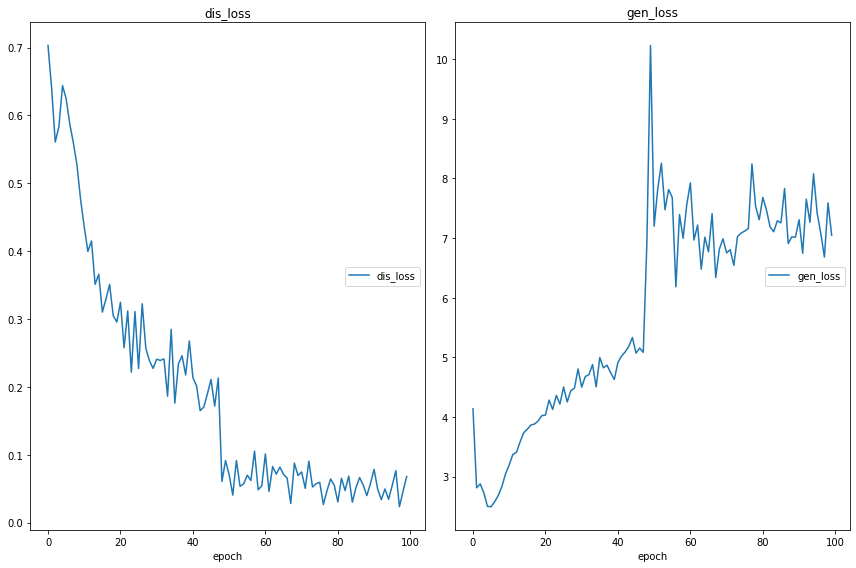

INFO:tensorlayer:[*] Saving TL weights into checkpoint/G.npz
INFO:tensorlayer:[*] Saved
INFO:tensorlayer:[*] Saving TL weights into checkpoint/D.npz
INFO:tensorlayer:[*] Saved


dis_loss
	dis_loss         	 (min:    0.023, max:    0.703, cur:    0.068)
gen_loss
	gen_loss         	 (min:    2.496, max:   10.228, cur:    7.047)


In [ ]:
def train():
    images, images_path = get_celebA(flags.output_size, flags.n_epoch, flags.batch_size)
    # print('image',images.shape)
    G = get_generator([None, flags.z_dim])
    D = get_discriminator([None, flags.output_size, flags.output_size, flags.c_dim])

    G.train()
    D.train()

    d_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)
    g_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)

    n_step_epoch = int(len(images_path) // flags.batch_size)
    
    # Z = tf.distributions.Normal(0., 1.)
    for epoch in range(flags.n_epoch):
        loss_dis =0.
        loss_gen =0.
        for step, batch_images in enumerate(images):
            
            if batch_images.shape[0] != flags.batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape(persistent=True) as tape:
                # z = Z.sample([flags.batch_size, flags.z_dim]) 
                z = np.random.normal(loc=0.0, scale=1.0, size=[flags.batch_size, flags.z_dim]).astype(np.float32)
                d_logits = D(G(z))
                d2_logits = D(batch_images)
                # discriminator: real images are labelled as 1
                d_loss_real = tl.cost.sigmoid_cross_entropy(d2_logits, tf.ones_like(d2_logits), name='dreal')
                # discriminator: images from generator (fake) are labelled as 0
                d_loss_fake = tl.cost.sigmoid_cross_entropy(d_logits, tf.zeros_like(d_logits), name='dfake')
                # combined loss for updating discriminator
                d_loss = d_loss_real + d_loss_fake
                loss_dis += d_loss.numpy().mean()
                
                # generator: try to fool discriminator to output 1
                g_loss = tl.cost.sigmoid_cross_entropy(d_logits, tf.ones_like(d_logits), name='gfake')
                loss_gen += g_loss.numpy().mean()
            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
            del tape

            print("Epoch: [{}/{}] [{}/{}] took: {:.3f}, d_loss: {:.5f}, g_loss: {:.5f}".format(epoch, \
                  flags.n_epoch, step, n_step_epoch, time.time()-step_time, d_loss, g_loss))
            
        generate_and_save_images(G,
                             epoch + 1,
                             seed)
        loss_gen = loss_gen/(n_step_epoch)
        loss_dis = loss_dis/(n_step_epoch)
        draw_loss(loss_gen,loss_dis)

        if np.mod(epoch, flags.save_every_epoch) == 0:
            G.save_weights('{}/G.npz'.format(flags.checkpoint_dir), format='npz')
            D.save_weights('{}/D.npz'.format(flags.checkpoint_dir), format='npz')
            z = np.random.normal(loc=0.0, scale=1.0, size=[flags.batch_size, flags.z_dim]).astype(np.float32)
            G.eval()
            result = G(z)
            G.train()
            tl.visualize.save_images(result.numpy(), [num_tiles, num_tiles], '{}/train_{:02d}.png'.format(flags.sample_dir, epoch))

if __name__ == '__main__':
    train()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)